# CSE 6367 Programming Assignment 3 (P3)

## Spring 2024
## Due: 11:59pm Central Time, Friday, March 15, 2024

### Task 1 (30 points)

Implement Hough transform from scratch to detect circles in the image. Refer to this wiki page for pseudocode(https://en.wikipedia.org/wiki/Circle_Hough_Transform). Superimpose detected circles on the original image.

Note: You shouldn't use cv2.HoughCircles() or any other library fuctions to detect the circles.

<img src = Images/coins.png>

For each A[a,b,r] = 0; // fill with zeroes initially, instantiate 3D matrix
  For each cell(x,y)
      For each theta t = 0 to 360  // the possible  theta 0 to 360
         b = y – r * sin(t * PI / 180);  //polar coordinate for center (convert to radians)
         a = x – r * cos(t * PI / 180); //polar coordinate for center (convert to radians)
         A[a,b,r] +=1; //voting
      end
  end

In [1]:
#Smooth the image to remove the noise
import cv2
import numpy as np
import matplotlib.pyplot as plt
image = cv2.imread('coins.png',0)
blur_img = cv2.GaussianBlur(image, (5,5), 1.4)
blur_img = np.float32(blur_img)

In [2]:
# Sobel gradients
gx = cv2.Sobel(blur_img, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(blur_img, cv2.CV_64F, 0, 1, ksize=3)

G = np.hypot(gx, gy)

#G = G / G.max() * 255

theta = np.arctan2(gy, gx)

In [3]:
#Apply non-maximum suppression
M, N = G.shape
Z = np.zeros((M,N), dtype=np.int32)
angle = theta * 180. / np.pi    # max -> 180, min -> -180
angle[angle < 0] += 180         # max -> 180, min -> 0

for i in range(1,M-1):
    for j in range(1,N-1):
        q = 255
        r = 255

        #angle 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
            r = G[i, j-1]
            q = G[i, j+1]
        #angle 45
        elif (22.5 <= angle[i,j] < 67.5):
            r = G[i-1, j+1]
            q = G[i+1, j-1]
        #angle 90
        elif (67.5 <= angle[i,j] < 112.5):
            r = G[i-1, j]
            q = G[i+1, j]
        #angle 135
        elif (112.5 <= angle[i,j] < 157.5):
            r = G[i+1, j+1]
            q = G[i-1, j-1]

        if (G[i,j] >= q) and (G[i,j] >= r):
            Z[i,j] = G[i,j]
        else:
            Z[i,j] = 0



In [4]:
#Apply double threshold.
def threshold(img, lowThresholdRatio=0.10, highThresholdRatio=0.20):

    #Using two thresholds low and high thresholds to categorize strong, weak and non-edges
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)
    #Any edges with intensity gradient more than highThreshold are sure to be edges and those below lowThreshold are sure to be non-edges, so discarded automatically
    #Wweak edges are considered to be edges if they are connected to strong edges
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)


    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)
thresholded = threshold(Z,0.6)[0]

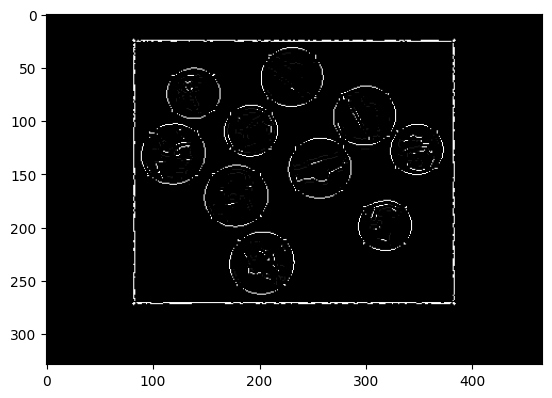

In [5]:
#Select edge pixels by hysteresis (suppress all edges that are weak and not connected to strong edges).

def hysteresis(img, weak=60, strong=255):
#Weak edges are considered to be edges if they are connected to strong edges.
    M, N = img.shape
    #Checking the strong edges near(adjacent) to the weak edges
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == weak):
                if (
                    (img[i+1, j-1] == strong) or (img[i+1, j] == strong) or
                    (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or
                    (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or
                    (img[i-1, j] == strong) or (img[i-1, j+1] == strong)
                ):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img


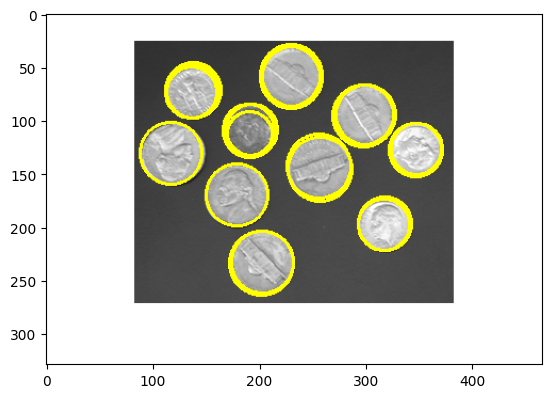

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def circle_detection(accum, thresh):
    detected = np.where(accum > thresh)
    return list(zip(detected[1], detected[0], detected[2]))

def visualize_circles(pic, detected_circles, min_radius):
    for centerX, centerY, radiusIndex in detected_circles:
        cv2.circle(pic, (centerX, centerY), radiusIndex + min_radius, (0, 255, 255), 2)
    plt.imshow(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB))
    plt.show()

def perform_hough_transform(edge_img, min_rad, max_rad, theta_count=100):
    img_height, img_width = edge_img.shape
    theta = np.linspace(0, 2 * np.pi, 360) #For each theta t = 0 to 360
    aCCumulator_aRray = np.zeros((img_height, img_width, max_rad-min_rad)) #For each A[a,b,r] = 0; // fill with zeroes initially, instantiate 3D matrix
    edge_y, edge_x = np.where(edge_img)
    for radius_index, radius in enumerate(range(min_rad, max_rad)): #  For each cell(x,y)
        for angle_index in range(theta_count): #For each theta t = 0 to 360
            a = edge_x - radius * np.cos(angle_index)
            b = edge_y - radius * np.sin(angle_index)
            valid = (a >= 0) & (a < img_width) & (b >= 0) & (b < img_height) #Checking for valid dimensions as the difference should be between 0 and width/height
            aCCumulator_aRray[b[valid].astype(int), a[valid].astype(int), radius_index] += 1 #A[a,b,r] +=1; //voting

    return aCCumulator_aRray

# Load and process the image
image = cv2.imread('coins.png')
#image = cv2.GaussianBlur(image,(5,5),1.4)
# Edge detection
edges_detected = hysteresis(thresholded)

#plt.imshow(edges_detected)
# Hough Circle Transform application
accumulator = perform_hough_transform(edges_detected, 20, 110)#Taken from 2nd assignment

# Circle detection
circles_found = circle_detection(accumulator, 32)
# Drawing circles on the image
visualize_circles(image, circles_found, 20)


### Task 2 (30 points)

Implement Harris corner detector from scratch. Mark detected corners on original image.

Note: You shouldn't use cv2.cornerHarris() or any other library functions to detect the corners.

<img src = Images/checkerboard.jpg>

In [7]:
# Load the image
image = cv2.imread('checkerboard.jpg')
#Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [8]:
#Harris Corner Detection Algorithm:
#1. Compute x and y derivatives of image
Ix = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)

In [9]:
#2.Compute products of derivatives at every pixel
Ixx = Ix**2
Ixy = Ix * Iy
Iyy = Iy**2

In [10]:
#3.Compute the sums of the products of derivatives at
#each pixel
#3.Compute the sums of the products of derivatives at each pixel by applying Gaussian of products of derivatives
from scipy.signal import convolve2d
kernel_size = 3
sigma = 1
gauss_kernel = cv2.getGaussianKernel(kernel_size, sigma)
gauss_kernel = gauss_kernel * gauss_kernel.T
Sxx = convolve2d(Ixx, gauss_kernel)
Syy = convolve2d(Iyy, gauss_kernel)
Sxy = convolve2d(Ixy, gauss_kernel)

In [11]:
#4.Compute the response of the detector at each pixel
det_M = Sxx * Syy - Sxy**2
trace_M = Sxx + Syy
k=0.04
corner_response = det_M - k * (trace_M**2)

In [12]:
#5.Apply threshold on value of R at 10%
corner_response[corner_response < 0.1 * np.max(corner_response)] = 0


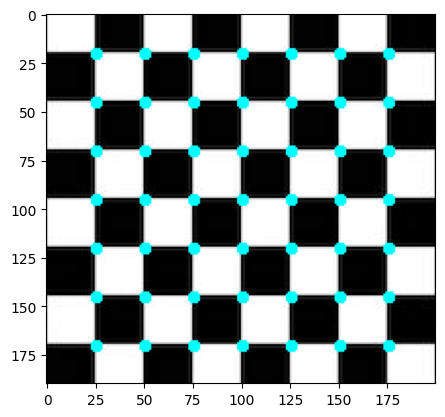

In [13]:
#6.Non-maxx suppression
y, x = np.where(corner_response > 0)
#c = 0
for x_val, y_val in zip(x, y):
  cv2.circle(image, (x_val, y_val), 1, (0, 255, 255), -1)

plt.imshow(image)

### Task 3 (40 points)

Implement multiscale template matching that measures the SSD differences (normalized for brightness but NOT for contrast) between the template and each location of the image at multiple scales. Both image and template are grayscale images. For this task, consider a linear range of scales, np.arange( 0.5, 3, .25). Show your top 9 matches and the scales for those matches in a 3X3 plot.

Template: <img src = Images/template.png>

Test Image: <img src = Images/test_image.png style="width:537px; height:400px">

Hint: function multiscale_correlation (in the slides) has many similarities with the function that you are asked to implement. The only difference is that multiscale_correlation computes scores based on normalized cross-correlation, whereas your scores are based on SSD differences after brightness normalization.

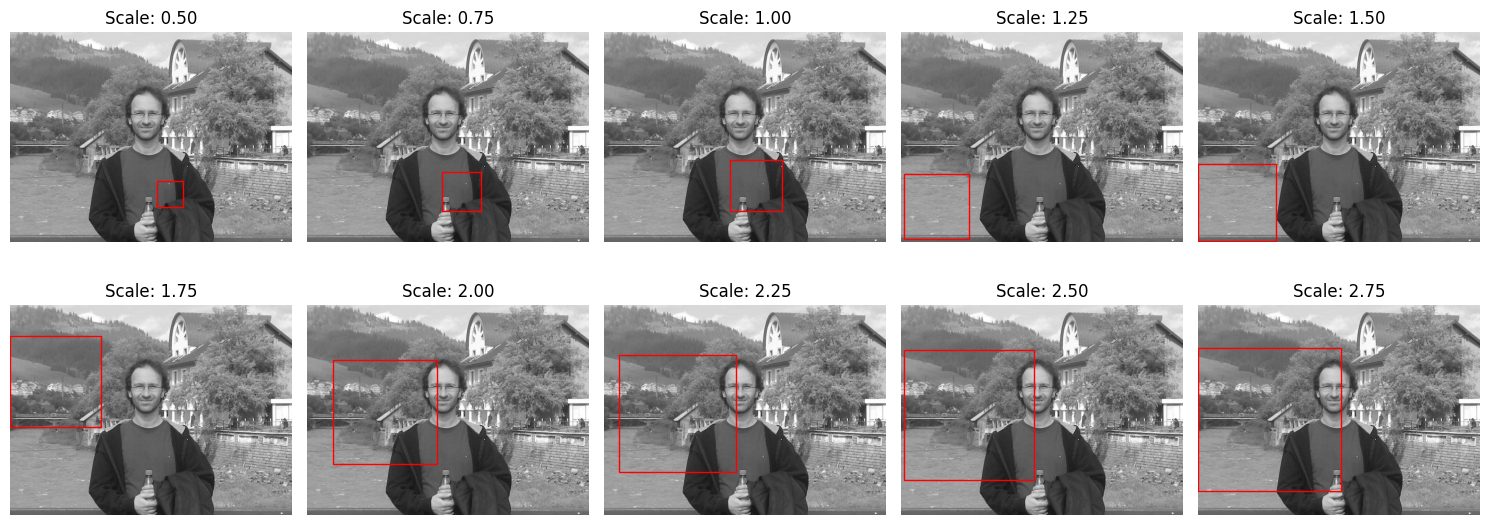

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches



def resize_image(template, scale):
    # Resize image using bilinear interpolation
    resized_image = cv2.resize(template, (int(template.shape[1] * scale), int(template.shape[0] * scale)), interpolation=cv2.INTER_LINEAR)
    return resized_image - np.mean(resized_image) # Subtract from mean to account for image brightness normalization

def multiscale_correlation(image,template,scales):

    #Resizing template as per scale and accounting for brightness normalization
    normalized_templates = [resize_image(template, scale) for scale in scales]
    #Plotting a 2 * 5 plot for all 10 scales
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))

    for i, (scale, normalized_template) in enumerate(zip(scales, normalized_templates)):
        #Taking the below values to find the minimum SSD value and its location
        best_match_ssd = float('inf')
        best_match_location = None

        for y in range(image.shape[0] - normalized_template.shape[0]):
            for x in range(image.shape[1] - normalized_template.shape[1]):
                patch = image[y:y+normalized_template.shape[0], x:x+normalized_template.shape[1]]-np.mean(image[y:y+normalized_template.shape[0], x:x+normalized_template.shape[1]])
                ## Subtracted from mean to account for image brightness normalization
                # Calculate SSD
                current_ssd = np.sum((normalized_template - patch) ** 2)
                # Update best match to the minimum SSD value
                if current_ssd < best_match_ssd:
                    best_match_ssd = current_ssd
                    best_match_location = (x, y)

        # Plot the best match as a 2 * 5 plot
        ax = axs[i // 5, i % 5]
        ax.imshow(image, cmap='gray')
        ax.add_patch(patches.Rectangle((best_match_location[0], best_match_location[1]), normalized_template.shape[1], normalized_template.shape[0], linewidth=1, edgecolor='r', facecolor='none'))
        ax.set_title(f'Scale: {scale:.2f}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


template = cv2.imread('template.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('test_image.png', cv2.IMREAD_GRAYSCALE)
scales = np.arange(0.5, 3, 0.25)

#Multiscale Search
multiscale_correlation(image,template,scales)


## Submission Guidelines:

    Submit through Canvas your source code in a single .ipynb file. The name of the .ipynb file should be YourStudentID.ipynb. (For example: 1001234567.ipynb)
    Import all the images from the ./Images directory. Your TA will use the same directory name to grade your submission.
    You don't need to attach the image file with your submission.


References:
https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html
https://meghal-darji.medium.com/implementing-bilinear-interpolation-for-image-resizing-357cbb2c2722